In [24]:
#https://machinelearningmastery.com/stateful-stateless-lstm-time-series-forecasting-python/
#https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/


# univariate multi-step vector-output stacked lstm example
# Importing the libraries
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional,Dropout
from keras.layers import Dense
from keras.regularizers import L1L2
from numpy import hstack
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import mean_squared_error
import seaborn as sns

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.compat.v1.Session(config=config)

def plot_eval(real_stock_price, predicted_stock_price):
    print("sqrt mean_squared_error: ", sqrt(mean_squared_error(real_stock_price, predicted_stock_price)))
    print("mean_squared_error: ", mean_squared_error(real_stock_price, predicted_stock_price))
    mean_absolute_er = mean_absolute_error(real_stock_price, predicted_stock_price)
    print("mean_absolute_error: ", mean_absolute_er)
    
    #real_stock_price, predicted_stock_price
    SS_Residual = sum((real_stock_price-predicted_stock_price)**2)
    SS_Total = sum((real_stock_price-np.mean(real_stock_price))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    adjusted_r_squared = 1 - (1-r_squared)*(len(real_stock_price)-1)/(len(real_stock_price)-X_train.shape[1]-1)
    print ("R Squared:", r_squared, "\nAdjusted R Squared:", adjusted_r_squared)
    out_arr = np.subtract(predicted_stock_price, real_stock_price)
    fig = plt.figure(figsize=(12,8))
    # Visualising the results
    plt.plot(real_stock_price, color = 'red',  marker='o', label = 'Real Stock Price')
    plt.plot(predicted_stock_price, color = 'blue',  marker='o', label = 'Predicted Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

def add_datepart(df, fldnames, drop=False, time=False, errors="raise"):	
    if isinstance(fldnames,str):
        fldnames = [fldnames]
    for fldname in fldnames:
        fld = df[fldname]
        fld_dtype = fld.dtype
        if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
            fld_dtype = np.datetime64
        if not np.issubdtype(fld_dtype, np.datetime64):
            df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
        #targ_pre = re.sub('[Dd]ate$', '', fldname)
        attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
                'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
        if time: attr = attr + ['Hour', 'Minute', 'Second']
        for n in attr: df[n] = getattr(fld.dt, n.lower())
        df['Elapsed'] = fld.astype(np.int64) // 10 ** 9
        if drop: df.drop(fldname, axis=1, inplace=True)
    df.drop(['Elapsed','Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'], axis=1, inplace=True)
        

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)


def calc_feat(sequence, n_steps_in, n_steps_out):
    X= []
    k = 0 # row itreator
    size = len(sequence)
    for i in range(n_steps_in, size):
        vwap = 0
        vol = 0
        vchg = 0
        for j in range(n_steps_in):
            if (k<i):
#                print("i:", i," j:",j)
#                print("High, Low, Close", sequence[k, 0:3])
#                print("Vol", sequence[k, 4])
#                print("Change", sequence[k, 3])
                vwap += (((np.sum(sequence[k, 0:3]))/3) * sequence[k, 4])
                vchg += (((sequence[k, 3])) * sequence[k, 4])
                vol += sequence[k, 4]
                k = k+1
 #               print("vwap:", vwap, " vchg", vchg)
        #if vwap !=0  and vol != 0:
        
        X = np.append(X, vwap/vol) #vwap
        X = np.append(X, vchg/vol) #Change
        #X = np.append(X, sequence[i, 4]) #volume
        #X = np.append(X, sequence[i, 5]) #openInt
        #X = np.append(X, sequence[i, 6]) #DTWEXB
        #X = np.append(X, sequence[i, 7]) #Year
        #X = np.append(X, sequence[i, 8]) #Mnt
        #X = np.append(X, sequence[i, 9]) #Week
        #X = np.append(X, sequence[i, 10]) #DayofMonth
        #X = np.append(X, sequence[i, 11]) #Dayofweek
        #X = np.append(X, sequence[i, 12]) #Dayofyear
    
    num_of_features = 2 #num_of_features
    sz = size-(n_steps_in)
    X = np.array(X.reshape(sz, num_of_features)) 
    #X = X[:-(n_steps_out), :]
    return X


# load dataset
# Importing the training set
dataset_train = pd.read_csv('C:/Users/hmnsh/repos/datastuff/Minnean/marketdata/zsh20_daily_price-history-11-11-2019.csv') #, nrows=10
#dataset_train = dataset_train[dataset_train["Volume"] != 0]

#dataset_dxy = pd.read_csv('C:/Users/hmnsh/repos/datastuff/Minnean/marketdata/DTWEXB.csv')
#dataset_train = pd.merge(dataset_train, dataset_dxy,  left_on='Time', right_on='Time', how='left')

dataset_train.Time = pd.to_datetime(dataset_train.Time.str.replace('D', 'T'))
dataset_train = dataset_train.sort_values('Time')
# choose a number of time steps
n_steps_in, n_steps_out = 4, 15

add_datepart(dataset_train, 'Time')

dataset_train.set_index('Time', inplace=True)
print(dataset_train.shape)

# define input sequence
training_feat = dataset_train.iloc[:, 1:15].values

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (-1, 1))
training_feat_scaled = sc.fit_transform(training_feat)

#X_feat = calc_feat(training_feat, n_steps_in, n_steps_out)
X_feat = calc_feat(training_feat_scaled, n_steps_in, n_steps_out)

# define input sequence
training_set = dataset_train.iloc[:, 3:4].values

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (-1, 1))
raw_seq = sc.fit_transform(training_set)

# split into samples
X_whole, y_whole = split_sequence(raw_seq, n_steps_in, n_steps_out)

# summarize the data
#for i in range(len(X_whole)):
#	print(X_whole[i], y_whole[i])

X_whole = X_whole.reshape(X_whole.shape[0], X_whole.shape[1])
y_whole = y_whole.reshape(y_whole.shape[0], y_whole.shape[1])

#step2 model - drop 1st row
n_steps_out = 1
y_whole = y_whole[:,14:15]

trp_rows = X_feat.shape[0] - X_whole.shape[0]
if trp_rows>0:
    X_feat = X_feat[:-(trp_rows), :]
#Concate features
X_whole = hstack((X_whole, X_feat))
print(X_whole.shape)

(500, 13)
(482, 6)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

dict_keys(['loss', 'mean_squared_error'])


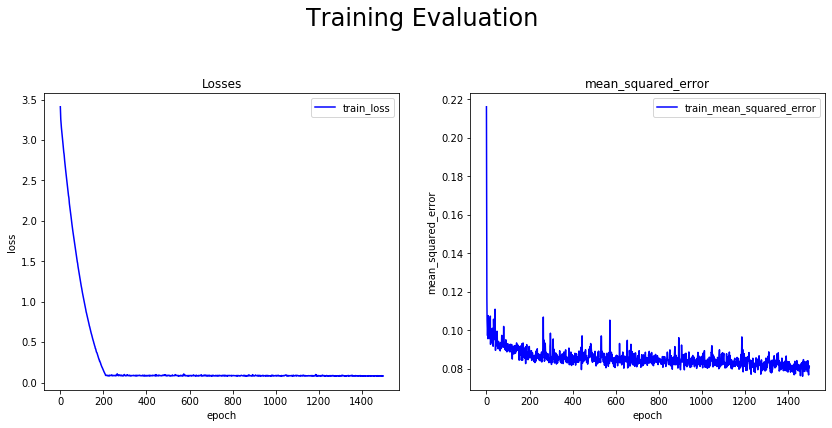

In [25]:
#Train -valid and Test split in time order
X_train = X_whole[0:362,:].copy()
X_valid = X_whole[362:420,:].copy()
X_test = X_whole[420:,:].copy()

y_train = y_whole[0:362].copy()
y_valid = y_whole[362:420].copy()
y_test = y_whole[420:].copy()

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
Xf_whole = X_whole.reshape((X_whole.shape[0], X_whole.shape[1], n_features))

# define model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(Xf_whole.shape[1], n_features)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True,bias_regularizer=L1L2(l1=0.01, l2=0.01)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True,bias_regularizer=L1L2(l1=0.01, l2=0.01)))
model.add(Dropout(0.2))
model.add(LSTM(10,bias_regularizer=L1L2(l1=0.01, l2=0.01)))
model.add(Dropout(0.2))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse', metrics=["mean_squared_error"])
# fit model , batch_size=32
hist = model.fit(Xf_whole, y_whole, epochs=1500, verbose=0, batch_size=96)
# demonstrate prediction
plt.figure(figsize=(14,12))
plt.suptitle('Training Evaluation', fontsize=24)

plt.subplot(2,2,1)
#Plotting Training history
print(hist.history.keys())

# Visualising the results
plt.plot(hist.history['loss'], color = 'blue',  label = 'train_loss')
#plt.plot(hist.history['val_loss'], color = 'red',  label = 'val_loss')
plt.title('Losses')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
#plt.show()
plt.subplot(2,2,2)
# Visualising the results
plt.plot(hist.history['mean_squared_error'], color = 'blue',  label = 'train_mean_squared_error')
##plt.plot(hist.history['val_mean_squared_error'], color = 'red',  label = 'val_mean_squared_error')
plt.title('mean_squared_error')
plt.xlabel('epoch')
plt.ylabel('mean_squared_error')
plt.legend()
plt.show()

# demonstrate prediction
#yhat = model.predict(X_test, verbose=0)

#for col in range(yhat.shape[1]):
#    print("Day Prediction (Step): ", col+1)
#    yhat[:,col:col+1] = sc.inverse_transform(yhat[:,col:col+1])
#    y_test[:,col:col+1] = sc.inverse_transform(y_test[:,col:col+1])
#    plot_eval(y_test[:,col:col+1],yhat[:,col:col+1])

0.37144591557044604
[04:32:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9877803730693662 -0.6572875488967163
0.41246441906343234
sqrt mean_squared_error:  33.30649795969886
mean_squared_error:  1109.3228063394245
mean_absolute_error:  25.36541043795072
R Squared: [-0.65728716] 
Adjusted R Squared: [-1.01242013]


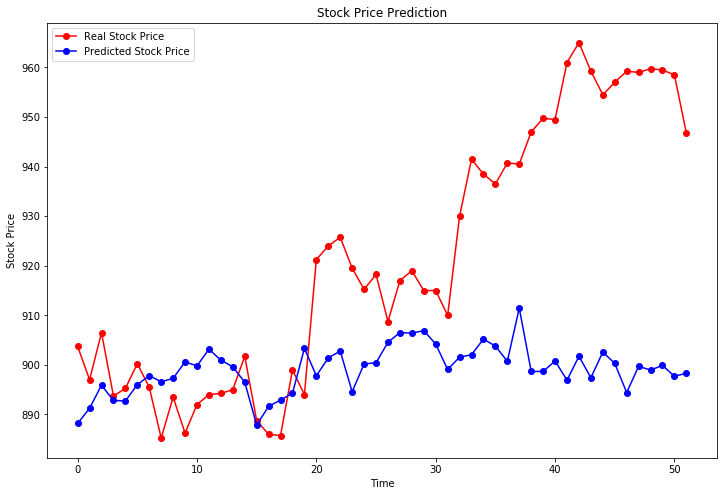

In [18]:
#Train -valid and Test split in time order
X_train = X_whole[0:362,:].copy()
X_valid = X_whole[362:420,:].copy()
X_test = X_whole[420:,:].copy()

y_train = y_whole[0:362].copy()
y_valid = y_whole[362:420].copy()
y_test = y_whole[420:].copy()

from sklearn.linear_model import LassoCV, RidgeCV, ElasticNet
from sklearn.model_selection import cross_val_score
elastic = ElasticNet(alpha=0.001)
print(np.sqrt(-cross_val_score(elastic, X_train, y_train, cv=5, scoring='neg_mean_squared_error')).mean())


from sklearn.metrics import mean_squared_error as MSE
from xgboost.sklearn import XGBRegressor
reg=XGBRegressor(learning_rate=0.01, n_estimators=1500, n_jobs=1)
reg.fit(X_train, y_train)
print(reg.score(X_train, y_train), reg.score(X_test, y_test))
print(np.sqrt(MSE(y_test, reg.predict(X_test))))
predicted_stock_price = reg.predict(X_test)

#create empty table with 6 fields to inverse
real_stock_price = sc.inverse_transform(y_test)

# Part 3 - Making the predictions and visualising the results
#real_stock_price = sc.inverse_transform(y_test.reshape(-1, 1))
# create empty table with 6 fields to inverse
predicted_stock_price = sc.inverse_transform(predicted_stock_price.reshape(-1, 1))

#predicted_stock_price = sc.inverse_transform(predicted_stock_price)

from sklearn.metrics import mean_absolute_error
from math import sqrt
# report performance
from sklearn.metrics import mean_squared_error
print("sqrt mean_squared_error: ", sqrt(mean_squared_error(real_stock_price, predicted_stock_price)))
print("mean_squared_error: ", mean_squared_error(real_stock_price, predicted_stock_price))
mean_absolute_error = mean_absolute_error(real_stock_price, predicted_stock_price)
print("mean_absolute_error: ", mean_absolute_error)

#real_stock_price, predicted_stock_price
SS_Residual = sum((real_stock_price-predicted_stock_price)**2)
SS_Total = sum((real_stock_price-np.mean(real_stock_price))**2)
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(real_stock_price)-1)/(len(real_stock_price)-X_train.shape[1]-1)
print ("R Squared:", r_squared, "\nAdjusted R Squared:", adjusted_r_squared)

fig = plt.figure(figsize=(12,8))
# Visualising the results
plt.plot(real_stock_price, color = 'red',  marker='o', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue',  marker='o', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
reg.feature_importances_

#### lightgbm

Training and making predictions
sqrt mean_squared_error:  46.55185323604283
mean_squared_error:  2167.0750397100715
mean_absolute_error:  38.40808329226643


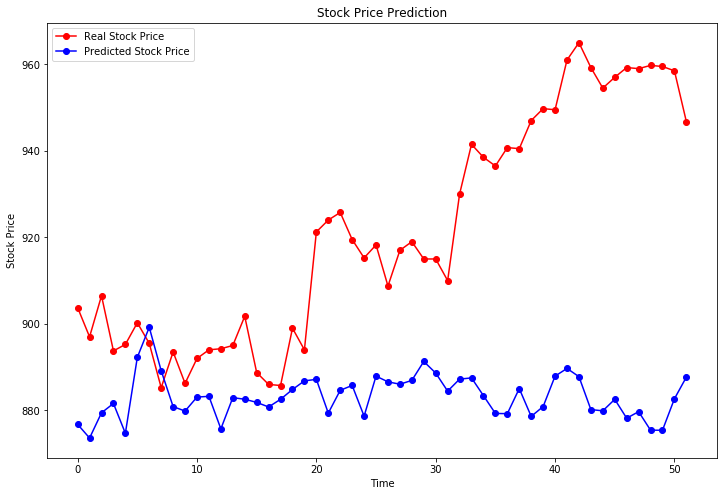

In [15]:
import lightgbm as lgb
def rmsle(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return np.sqrt(np.mean(np.power(np.log1p(y_true + 1) - np.log1p(y_pred + 1), 2)))


print('Training and making predictions')
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'max_depth': 6, 
    'learning_rate': 0.1,
    'verbose': 0, 
    'metric': 'rmsle'}

n_estimators = 1000

n_iters = 5
preds_buf = []
err_buf = []

#Train -valid and Test split in time order
X_train = X_whole[0:362,:].copy()
X_valid = X_whole[362:420,:].copy()
X_test = X_whole[420:,:].copy()

y_train = y_whole[0:362].copy().ravel()
y_valid = y_whole[362:420].copy().ravel()
y_test = y_whole[420:].copy().ravel()


d_train = lgb.Dataset(X_train, label=y_train)
d_valid = lgb.Dataset(X_valid, label=y_valid)
watchlist = [d_valid]

model = lgb.train(params, d_train, n_estimators, watchlist, verbose_eval=1)
predicted_stock_price = model.predict(X_test)
real_stock_price = sc.inverse_transform(y_test.reshape(-1, 1))

# Part 3 - Making the predictions and visualising the results
#real_stock_price = sc.inverse_transform(y_test.reshape(-1, 1))
predicted_stock_price = sc.inverse_transform(predicted_stock_price.reshape(-1,1))

#predicted_stock_price = sc.inverse_transform(predicted_stock_price)

from sklearn.metrics import mean_absolute_error
from math import sqrt
# report performance
from sklearn.metrics import mean_squared_error
print("sqrt mean_squared_error: ", sqrt(mean_squared_error(real_stock_price, predicted_stock_price)))
print("mean_squared_error: ", mean_squared_error(real_stock_price, predicted_stock_price))
mean_absolute_error = mean_absolute_error(real_stock_price, predicted_stock_price)
print("mean_absolute_error: ", mean_absolute_error)
fig = plt.figure(figsize=(12,8))
# Visualising the results
plt.plot(real_stock_price, color = 'red',  marker='o', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue',  marker='o', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## RandomForest

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.9938103593004315 -2.9786959173128236
0.6390839794233522
sqrt mean_squared_error:  51.60603133843569
mean_squared_error:  2663.182470503607
mean_absolute_error:  44.96807211538463


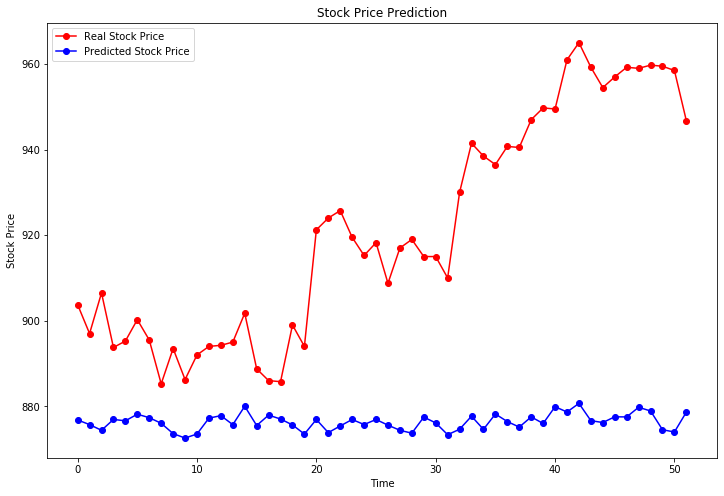

In [7]:
from sklearn.metrics import mean_squared_error as MSE

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=1000)
rf.fit(X_train, y_train)
print(rf.score(X_train, y_train), rf.score(X_test, y_test))
print(np.sqrt(MSE(y_test, rf.predict(X_test))))
predicted_stock_price = rf.predict(X_test)
real_stock_price = sc.inverse_transform(y_test)

# Part 3 - Making the predictions and visualising the results
#real_stock_price = sc.inverse_transform(y_test.reshape(-1, 1))
predicted_stock_price = sc.inverse_transform(predicted_stock_price.reshape(-1, 1))

#predicted_stock_price = sc.inverse_transform(predicted_stock_price)

from sklearn.metrics import mean_absolute_error
from math import sqrt
# report performance
from sklearn.metrics import mean_squared_error
print("sqrt mean_squared_error: ", sqrt(mean_squared_error(real_stock_price, predicted_stock_price)))
print("mean_squared_error: ", mean_squared_error(real_stock_price, predicted_stock_price))
mean_absolute_error = mean_absolute_error(real_stock_price, predicted_stock_price)
print("mean_absolute_error: ", mean_absolute_error)

fig = plt.figure(figsize=(12,8))
# Visualising the results
plt.plot(real_stock_price, color = 'red',  marker='o', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue',  marker='o', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.983732243711748 -0.703596460535113
0.4181873786383315
sqrt mean_squared_error:  33.768630825045264
mean_squared_error:  1140.3204277981972
mean_absolute_error:  26.2354380450911


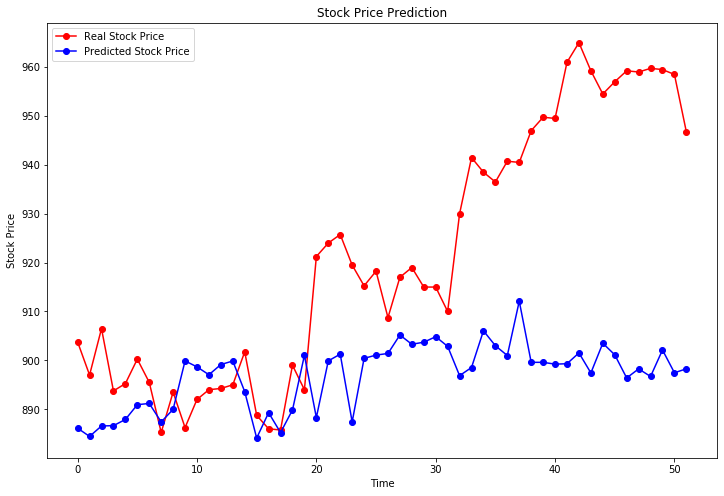

In [22]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)
print(gb.score(X_train, y_train), gb.score(X_test, y_test))
print(np.sqrt(MSE(y_test, gb.predict(X_test))))

predicted_stock_price = gb.predict(X_test)
real_stock_price = sc.inverse_transform(y_test.reshape(-1, 1))

# Part 3 - Making the predictions and visualising the results
#real_stock_price = sc.inverse_transform(y_test.reshape(-1, 1))
predicted_stock_price = sc.inverse_transform(predicted_stock_price.reshape(-1, 1))

#predicted_stock_price = sc.inverse_transform(predicted_stock_price)

from sklearn.metrics import mean_absolute_error
from math import sqrt
# report performance
from sklearn.metrics import mean_squared_error
print("sqrt mean_squared_error: ", sqrt(mean_squared_error(real_stock_price, predicted_stock_price)))
print("mean_squared_error: ", mean_squared_error(real_stock_price, predicted_stock_price))
mean_absolute_error = mean_absolute_error(real_stock_price, predicted_stock_price)
print("mean_absolute_error: ", mean_absolute_error)

fig = plt.figure(figsize=(12,8))
# Visualising the results
plt.plot(real_stock_price, color = 'red',  marker='o', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue',  marker='o', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()